<p style="font-family:verdana;color:black;font-size:18px;line-height: 1.4em;text-align:center;">
    <span style="color:black;font-size:25px"><b><u>Big Data Intelligence</u> </b></span><br>
    <span style="color:black"><b>Assignment 2</b></span><br>
    <span style="color:gray"><b>Predicting wind energy production with Scikit-Learn</b></span>
</p>

<p style="font-family:Times;color:black;font-size:15px;line-height: 1.4em;text-align:center;">
    <span style="color:black"><b><u>Team Members</u></b></span><br>
    <span style="color:black">Jose Antonio Jijon Vorbeck - 100438045</span><br>
    <span style="color:black">Didier Renzo Dirks - 100443386</span><br>
</p>

This assignment is divided into three steps. 

The first step consists on choosing the best model with best fitted hyper-parameters to be able to predict the energy outcome in the wind farm in Sotavento given weather variables from 25 measuring stations around Sotavento. 

The second stage of the project consists on selecting the best attributes for the model, since some of the variables might be redundandt or non-significant, and we would like to avoid that. We will see if it would be enough to use the variables at the measuring station only. 

There is also a preliminary step (step 0), in which the pre-processing steps are done, like for example deletion and imputation of random data, and standardization of the data. 

# Step 0 -- Some Preliminaries

In [2]:
# Import some useful libraries
import matplotlib.pyplot as plt 
%matplotlib inline  
import numpy as np              
import pandas as pd
import os
from numpy.random import randint
import pandas as pd
import regex as re
import optuna

# XGBoost
import xgboost as xgb
# LightBoost
import lightgbm as lgb

# Supressing warnings from Lightboost
import warnings
warnings.filterwarnings("ignore")

# Scikit-Learn
from sklearn import preprocessing, metrics, tree, neighbors
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, PredefinedSplit
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, f_regression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

# Scikit-Optimize 
from skopt import BayesSearchCV, forest_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
warnings.filterwarnings('ignore', message='WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.')
optuna.logging.set_verbosity(optuna.logging.WARNING)

The "wind_pickle" file contains data in a binary format called "Pickle". Pickle data loads faster than text data.

In [3]:
data = pd.read_pickle('wind_pickle.pickle')

You can visualize the attributes in the dataset. Very important, the output attribute (i.e. the value to be predicted, **energy**, is the first attribute). **Steps** represents the hours in advance of the forecast. We will not use this variable here.

In [4]:
# The dataset contains 5937 instances and 556 attributes (including 
# the outcome to be predicted)
print(data.shape)
#data.columns.values.tolist()

(5937, 556)


In [5]:
my_NIA = 100443386
np.random.seed(my_NIA)

how_many_nas = round(data.shape[0]*data.shape[1]*0.05)
print('Lets put '+str(how_many_nas)+' missing values \n')
x_locations = randint(0, data.shape[0],size=how_many_nas)
y_locations = randint(6, data.shape[1]-1,size=how_many_nas)

for i in range(len(x_locations)):
    data.iat[x_locations[i], y_locations[i]] = np.nan

data.to_pickle('wind_pickle_with_nan.pickle')

Lets put 165049 missing values 



From this point on, the file wind_pickle_with_nan should be used.

## Preprocessing

Here we will impute the missing values, standardize the data and drop the columns that are of no use for the analysis.

In [6]:
df = pd.read_pickle('wind_pickle_with_nan.pickle')
data = df.drop(columns=['steps', 'month', 'day', 'hour', 'year']).values

y = data[:,0] 

# Impute missing data
imp = SimpleImputer()
X = imp.fit_transform(data[:,1:])

# Standardize data
scaler = preprocessing.StandardScaler().fit(X) 
X = scaler.transform(X)

print(f'Shape of X matrix: {np.shape(X)}')
print(f'Size of y vector: {np.shape(y)}')

Shape of X matrix: (5937, 550)
Size of y vector: (5937,)


Splitting the data into Train, Validation and Test, each gets 2/6 of the data, (more or less 2 years of data for each)

In [ ]:
# Splitting into partitions per 2 years
trainlen = len(df[df['year'] <= 2006])
vallen = len(df[(df['year'] > 2006) & (df['year'] <= 2008)])
testlen = len(df[df['year'] > 2008])

X_train, y_train = X[:trainlen, :], y[:trainlen]
X_val, y_val = X[trainlen: trainlen + vallen, :], y[trainlen: trainlen+vallen]
X_trainval, y_trainval = X[: trainlen + vallen, :], y[: trainlen + vallen]
X_test, y_test = X[trainlen + vallen:, :], y[trainlen + vallen:]

for i in ["X_train", "y_train", "X_val", "y_val", "X_test", "y_test", "X_trainval", "y_trainval"]:
    print(f'Shape of {i}: {np.shape(eval(i))}')

# 1. MODEL SELECTION AND HYPER-PARAMETER TUNING

In this section we will work with 3 different models: 
* KNN
* Random Forest
* Gradiant Boosting
    - XGBoost
    - LightBoost

We will run different hyper-parameter tunning optiization methods to get the best model. 

**The error scores between the models will be compared at the end in a comparisson table, and a final model will be chosen from that comparisson.**

### *a. KNN*

**Default hiper-parameters**

In [8]:
# K --> no arguments - default parameters
knn = neighbors.KNeighborsRegressor().fit(X_train, y_train)
print(metrics.mean_absolute_error(y_train, knn.predict(X_train)))
knn_default = metrics.mean_absolute_error(y_val, knn.predict(X_val))
print(knn_default)

228.4554818037975
322.802831408776


now we will do hyper-parameter tuning for KNN using **skopt** and **Optuna**.

In [9]:
# split the validation and training partitions
n = np.zeros(trainlen + vallen)
n[:trainlen] = -1
tr_val_partition = tr_val_partition = PredefinedSplit(n)

### **Bayesian Search Skopt**

In [10]:
# Bayesian search for KNN
param_grid = {'n_neighbors': Integer(1,30),
              'p': Integer(1,2),
             'weights': ["uniform", "distance"],
             "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}

knn_bayesian = BayesSearchCV(neighbors.KNeighborsRegressor(), 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=tr_val_partition, 
                         n_jobs=4, n_iter=20
                        )

knn_bayesian.fit(X_trainval, y_trainval)

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              error_score='raise',
              estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
              fit_params=None, iid=True, n_iter=20, n_jobs=4, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False,
              scoring='neg_mean_absolute_error',
              search_spaces={'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                           'brute'],
                             'n_neighbors': Integer(low=1, high=30, prior='uniform', transform='identity'),
                             'p': Integer(low=1, high=

In [11]:
knn_bayes_sum = knn_bayesian.best_params_.copy()
knn_bayes_sum['best score'] = round(-knn_bayesian.best_score_,7)
knn_bayes_sum

OrderedDict([('algorithm', 'brute'),
             ('n_neighbors', 15),
             ('p', 1),
             ('weights', 'distance'),
             ('best score', 313.0016595)])

### **Optuna**

In [12]:
def objective(trial):
    knn_opt = neighbors.KNeighborsRegressor(n_neighbors=trial.suggest_int("n_neighbors", 1, 30), 
                                            p=trial.suggest_int("p", 1, 2),
                                            weights=trial.suggest_categorical('weights',["distance", "uniform"]),
                                            algorithm = trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']))
    
    scores = -cross_val_score(knn_opt, X_trainval, y_trainval, 
                              scoring='neg_mean_absolute_error', 
                              n_jobs=1,
                              cv=tr_val_partition)
    return scores.mean() 

np.random.seed(0)
knn_optuna = optuna.create_study(direction="minimize")
knn_optuna.optimize(objective, n_trials=20, n_jobs=4)

In [13]:
knn_optuna_sum = knn_optuna.best_params.copy()
knn_optuna_sum['best score']= round(knn_optuna.best_value,7)
knn_optuna_sum

{'algorithm': 'auto',
 'best score': 312.6089279,
 'n_neighbors': 17,
 'p': 1,
 'weights': 'distance'}

### *b. Random Forest*

Now, train ensemble techniques (Random Forest and Gradient Boosting) without and with hyper-parameter tuning, and compare them using the test partition.

**Default**

In [14]:
rf_default = RandomForestRegressor()
rf_default.fit(X_train, y_train)
rf_default_score =metrics.mean_absolute_error(y_val, rf_default.predict(X_val))
print(rf_default_score)

278.2453281755196


**Bayesian (Skopt)**

In [15]:
# Bayesian search for Random Forest
param_grid = {'n_estimators': Integer(1,125),
              'max_depth': list(range(10,110,10)) + [None],
             "min_samples_split": [2,5,10],
              "min_samples_leaf": [1,2,4],
              "bootstrap": [True, False],
              "max_features" : ['auto', 'sqrt']
             }

rf_bayesian = BayesSearchCV(RandomForestRegressor(), 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=tr_val_partition, 
                         n_jobs=4, n_iter=20, verbose=1
                        )

rf_bayesian.fit(X_trainval, y_trainval)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   43.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.2s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.1min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.8s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.2min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.7min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.9min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.1s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.8min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.2s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.9min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.0min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.0min finished


BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              error_score='raise',
              estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=...
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False,
              scoring='neg_mean_absolute_error',
   

In [16]:
rf_bayes_sum = rf_bayesian.best_params_.copy()
rf_bayes_sum['best score']= round(-rf_bayesian.best_score_,7)
rf_bayes_sum

OrderedDict([('bootstrap', True),
             ('max_depth', 100),
             ('max_features', 'auto'),
             ('min_samples_leaf', 4),
             ('min_samples_split', 10),
             ('n_estimators', 125),
             ('best score', 274.8243666)])

**Optuna**

In [17]:
# Optuna
def objective(trial):
    rf_opt = RandomForestRegressor(n_estimators=trial.suggest_int("n_estimators", 1, 125), 
                                            max_depth=trial.suggest_categorical("max_depth", list(range(10,110,10)) + [None]),
                                           min_samples_split=trial.suggest_categorical("min_samples_split", [2,5,10]),
                                            bootstrap=trial.suggest_categorical('bootstrap',[True, False]),
                                           min_samples_leaf=trial.suggest_categorical("min_samples_leaf", [1,2,4]),
                                            max_features=trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2']))
    
    scores = -cross_val_score(rf_opt, X_trainval, y_trainval, 
                              scoring='neg_mean_absolute_error', 
                              n_jobs=1,
                              cv=tr_val_partition)
    return scores.mean() 

np.random.seed(0)
rf_optuna = optuna.create_study(direction="minimize")
rf_optuna.optimize(objective, n_trials=20, n_jobs=4)

In [18]:
rf_optuna_sum = rf_optuna.best_params.copy()
rf_optuna_sum['best score']= round(rf_optuna.best_value,7)
rf_optuna_sum

{'best score': 273.9664752,
 'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 121}

### *c. Gradient Boosting*

**Default**

In [19]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
print(metrics.mean_absolute_error(y_train, gb.predict(X_train)))
gb_default = metrics.mean_absolute_error(y_val, gb.predict(X_val))
print(gb_default)

198.71078813187177
288.50233853700377


**Bayesian (SkOpt)**

In [20]:
param_grid = {"learning_rate": Real(low=0.05, high=0.2),
              'n_estimators': Integer(20,100),
              'subsample':[0.7,0.75,0.8,0.85,0.9,0.95],
              'max_depth': Integer(1,15),
              "min_samples_split": Real(low=0.001, high=1),
              "min_samples_leaf": Integer(20,80),
              "min_weight_fraction_leaf": Real(low=0.00001, high=0.01),
              "max_features":list(range(7,20,2))
             }

gb_bayesian = BayesSearchCV(GradientBoostingRegressor(warm_start=True), 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=tr_val_partition, 
                         n_jobs=4, n_iter=20
                        )

gb_bayesian.fit(X_trainval, y_trainval)

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              error_score='raise',
              estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='ls', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  m...
                             'min_samples_leaf': Integer(low=20, high=80, prior='uniform', transf

In [21]:
gb_bayes_sum = gb_bayesian.best_params_.copy()
gb_bayes_sum['best score']= round(-gb_bayesian.best_score_,7)
gb_bayes_sum

OrderedDict([('learning_rate', 0.1725544826411087),
             ('max_depth', 10),
             ('max_features', 15),
             ('min_samples_leaf', 47),
             ('min_samples_split', 0.12761456949858813),
             ('min_weight_fraction_leaf', 0.00738931182474084),
             ('n_estimators', 38),
             ('subsample', 0.8),
             ('best score', 275.7296622)])

**Optuna**

In [22]:
def objective(trial):
                
    gb_opt = GradientBoostingRegressor(learning_rate = trial.suggest_float("learning_rate",0.05,0.2),
                                      n_estimators = trial.suggest_int('n_estimators',10,100),
                                      subsample = trial.suggest_categorical("subsample", [0.6,0.7,0.75,0.8,0.85,0.9,0.95]),
                                      max_depth = trial.suggest_int('max_depth',1,15),
                                      min_samples_split = trial.suggest_float("min_samples_split",0.0001, 1),
                                      min_samples_leaf = trial.suggest_int("min_samples_leaf",20,80),
                                      min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf",0.0001,0.5),
                                      max_features = trial.suggest_categorical("max_features",[7,9,11,13,15,17,19,21]),
                                      warm_start=True) 
        
        
    scores = -cross_val_score(gb_opt, X_trainval, y_trainval, 
                              scoring='neg_mean_absolute_error', 
                              n_jobs=1,
                              cv=tr_val_partition)
    return scores.mean() 

np.random.seed(0)
gb_optuna = optuna.create_study(direction="minimize")
gb_optuna.optimize(objective, n_trials=20, n_jobs=4)

In [23]:
gb_optuna_sum = gb_optuna.best_params.copy()
gb_optuna_sum['best score']= round(gb_optuna.best_value,7)
gb_optuna_sum

{'best score': 289.1198666,
 'learning_rate': 0.17120213003447668,
 'max_depth': 15,
 'max_features': 9,
 'min_samples_leaf': 21,
 'min_samples_split': 0.39553724519367833,
 'min_weight_fraction_leaf': 0.007686555886978863,
 'n_estimators': 32,
 'subsample': 0.8}

### *d. XGBoost*

Now we will use a more engineerend version of Gradient Boosting called Extreme Gredient Boosting (XGBoosting). This consists on an optimized gradient boosting algorithm that works with parallel processing, tree prunning, handles missing values and regularizations. It is said to be very good at avoiding overfitting and the bias/variance mistakes that some other models have, according to Vishal Morde [towardsdatascience.com](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

**Default XGBoosting**

In [24]:
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train, y_train)
print(metrics.mean_absolute_error(y_train, xgboost.predict(X_train)))
xgboost_default = metrics.mean_absolute_error(y_val, xgboost.predict(X_val))
print(xgboost_default)

[18:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
201.02705192555354
286.51768225166967


**Bayesian Search (SkOpt)**

In [25]:
param_grid = {"learning_rate": Real(low=0.01, high=0.5),
              'max_depth': Integer(1,15),
              "min_child_weight" : Integer(1,10),
              "gamma": Real(low= 0, high = 0.4),
              "colsample_bytree" : Real(low = 0.3, high = 0.8),
              "subsample": [0.6,0.7,0.75,0.8,0.85,0.9,0.95],
              "reg_alpha": [0, 0.001, 0.005, 0.01, 0.05],
}

xgb_bayesian = BayesSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'), 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         cv=tr_val_partition, 
                         n_jobs=4, n_iter=20
                        )

xgb_bayesian.fit(X_trainval, y_trainval)

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              error_score='raise',
              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     importance_type='gain', learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     o...
                             'gamma': Real(low=0, high=0.4, prior='uniform', transform='identity'),
                             'learning_rate': Real(low=0.01, high=0.5, prior='uniform', transform='identity'),
                             'max_depth': Integer(low=1, high=15, prior='uniform', transform='identity'),
                   

In [26]:
xgb_bayes_sum = xgb_bayesian.best_params_.copy()
xgb_bayes_sum['best score']= round(-xgb_bayesian.best_score_,7)
xgb_bayes_sum

OrderedDict([('colsample_bytree', 0.7433622944092604),
             ('gamma', 0.2802307853273717),
             ('learning_rate', 0.042359855964878734),
             ('max_depth', 12),
             ('min_child_weight', 8),
             ('reg_alpha', 0.005),
             ('subsample', 0.6),
             ('best score', 276.3215159)])

**Optuna**

In [27]:
def objective(trial):
                
    xgb_opt = xgb.XGBRegressor(learning_rate = trial.suggest_float("learning_rate",0.01,1),
                                      n_estimators = trial.suggest_int('n_estimators',1,200),
                                      subsample = trial.suggest_categorical("subsample", [0.6,0.7,0.75,0.8,0.85,0.9,0.95]),
                                      max_depth = trial.suggest_int('max_depth',1,15),
                                        gamma = trial.suggest_float("gamma", 0, 0.4),
                                        min_child_weight = trial.suggest_int("min_child_weight",1,10),
                                        colsample_bytree = trial.suggest_float('colsample_bytree',0.3,0.8),
                                        reg_alpha = trial.suggest_categorical("reg_alpha", [0, 0.001, 0.005, 0.01, 0.05]),
                                        objective =trial.suggest_categorical('objective', ['reg:squarederror'])) 
        
        
    scores = -cross_val_score(xgb_opt, X_trainval, y_trainval, 
                              scoring='neg_mean_absolute_error', 
                              n_jobs=1,
                              cv=tr_val_partition)
    return scores.mean() 

np.random.seed(0)
xgb_optuna = optuna.create_study(direction="minimize")
xgb_optuna.optimize(objective, n_trials=20, n_jobs=4)

In [28]:
xgb_optuna_sum = xgb_optuna.best_params.copy()
xgb_optuna_sum['best score']= round(xgb_optuna.best_value,7)
xgb_optuna_sum

{'best score': 279.7236369,
 'colsample_bytree': 0.51103483319659,
 'gamma': 0.31223083292495046,
 'learning_rate': 0.11589604135960821,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 176,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.001,
 'subsample': 0.85}

### *e. LightBoost*

Light GBM is another Gradient Boositng framework based on desicion tree algorithms. It is faster in training and deliverying most optimized Hyper Parameters. I also uses less memory than its contestant XGBoost. And according to PRANJAL KHANDELWAL "It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter." [Which algorithm takes the crown: Light GBM vs XGBOOST?](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

In [29]:
train_data = lgb.Dataset(X_train, label=y_train)
bst = lgb.train({"verbosity":-1, "force_col_wise":True}, train_data)

print(metrics.mean_absolute_error(y_train, bst.predict(X_train)))
lgb_default = metrics.mean_absolute_error(y_val, bst.predict(X_val))
print(lgb_default)


82.11226523895816
277.77222673544605


In [30]:
SPACE = [
   Real(0.01, 0.5, name='learning_rate'),
   Integer(1, 15, name='max_depth'),
   Integer(1,10, name="min_child_weight"),
    Categorical([0.6,0.7,0.75,0.8,0.85,0.9,0.95],name="subsample"),
    Real(low = 0.3, high = 0.8,name="colsample_bytree"),
    Categorical([0, 0.001, 0.005, 0.01, 0.05],name="reg_alpha"),           
   Integer(2, 31, name='num_leaves')]

@use_named_args(SPACE)
def objective(**params):
    params['verbosity'] = -1
    params['force_col_wise'] = True
    lgb_opt = lgb.train(params, train_data)
    return metrics.mean_absolute_error(y_val, lgb_opt.predict(X_val))


results = forest_minimize(objective, SPACE, n_calls=20, n_jobs=4)
lgb_bayes_best_params = {i.name:j for (i,j) in zip(SPACE, results.x)}

In [31]:
lgb_bayes_sum = lgb_bayes_best_params.copy()
lgb_bayes_sum['best score']= round(results.fun,7)
lgb_bayes_sum

{'best score': 274.2091955,
 'colsample_bytree': 0.3167791889225895,
 'learning_rate': 0.033753121991024745,
 'max_depth': 9,
 'min_child_weight': 9,
 'num_leaves': 20,
 'reg_alpha': 0.005,
 'subsample': 0.95}

In [32]:
def objective(trial):
                
    param = {"learning_rate": trial.suggest_float("learning_rate",0.01,1),
             "num_iterations" : trial.suggest_int('num_iterations',1,200),
             "subsample" : trial.suggest_categorical("subsample", [0.6,0.7,0.75,0.8,0.85,0.9,0.95]),
             "max_depth" : trial.suggest_int('max_depth',1,20),
             "min_child_weight" : trial.suggest_int("min_child_weight",1,10),
             "colsample_bytree" : trial.suggest_float('colsample_bytree',0.3,0.8),
             "reg_alpha" : trial.suggest_categorical("reg_alpha", [0, 0.001, 0.005, 0.01, 0.05]),
             "num_leaves" : trial.suggest_int('num_leaves',2,31),
             "verbosity":-1,
             "force_col_wise":True
            }
    
    lgb_opt = lgb.train(param, train_data, verbose_eval=False)
    return metrics.mean_absolute_error(y_val, lgb_opt.predict(X_val))

np.random.seed(0)
lgb_optuna = optuna.create_study(direction="minimize")
lgb_optuna.optimize(objective, n_trials=20, n_jobs=4)

In [33]:
lgb_optuna_sum = lgb_optuna.best_params.copy()
lgb_optuna_sum['best score']= round(lgb_optuna.best_value,7)
lgb_optuna_sum

{'best score': 272.2901196,
 'colsample_bytree': 0.47381037951518423,
 'learning_rate': 0.043075923514380506,
 'max_depth': 15,
 'min_child_weight': 5,
 'num_iterations': 159,
 'num_leaves': 30,
 'reg_alpha': 0.05,
 'subsample': 0.95}

### Comparison between models

After we have developed the 5 different models with their Hyper-parameters, we are ready to make a comparisson between them. It is straight forward to make the comparisson since we have used the same validation data for all models. 
We have used 3 different methods for HP for each model. 
* Default Parameters
* Bayesian Search (SkOpt)
* Optuna Optimization

And we have 5 different models (KNN, Random Forest, Gradient Boosting, Extreme Gradient Boosting and Light Boosting). 

In [34]:
# 5 models and 3 HPT methods (default, skopt, optuna)
default = [knn_default, rf_default_score, gb_default, xgboost_default, lgb_default]
bayes = [knn_bayes_sum['best score'], rf_bayes_sum['best score'], gb_bayes_sum['best score'], xgb_bayes_sum['best score'], lgb_bayes_sum['best score']]
Optuna = [knn_optuna_sum['best score'], rf_optuna_sum['best score'], gb_optuna_sum['best score'], xgb_optuna_sum['best score'], lgb_optuna_sum['best score']]
scores_sum = pd.DataFrame([default, bayes, Optuna], columns=['KNN', 'Random Forest', 'Grad. Boosting', 'XGBoost', "LightBoost"], index=['Default HP', 'SkOpt', 'Optuna'] ).rename_axis('Mean Absolute Error', axis=1).round(3)
scores_sum

Mean Absolute Error,KNN,Random Forest,Grad. Boosting,XGBoost,LightBoost
Default HP,322.803,278.245,288.502,286.518,277.772
SkOpt,313.002,274.824,275.730,276.322,274.209
Optuna,312.609,273.966,289.120,279.724,272.290


### Selecting best model from Testing Data predictions

We can see from the table above that the best models are nearly always obtained using SkOpt, thus we select the resulting models with the tunned HP and we use them to predict the test dataset. The best of these algorithms will be selected as the best fit for this case.
Now we have the following 5 models to see which one delivers the best results:
* KNN with optuna HP
* Random Forest with SkOpt HP
* Grad. Boosting with SkOpt HP
* XGBoost with optuna HP
* LightBoost with optuna HP

Now we will train these models with their respective HyperParameters with the train+validation dataset, and will make predictions in the testing dataset. Then by comparisson of the results, we will select a best model, which will be our most accurate method with its corresponding Hyper Parameters.

In [35]:
# 5 models with best HP 

#knn
knn_final = neighbors.KNeighborsRegressor(**knn_optuna.best_params).fit(X_trainval, y_trainval)

#random forest
RF_final  = RandomForestRegressor(**rf_bayesian.best_params_).fit(X_trainval, y_trainval)

#gradient boosting
GB_final  = GradientBoostingRegressor(**gb_bayesian.best_params_).fit(X_trainval, y_trainval)
#Extreme Gradient Boosting
Xgb_final = xgb.XGBRegressor(**xgb_optuna.best_params).fit(X_trainval, y_trainval)
# Light Boosting
Lgb_final = lgb.train(lgb_optuna.best_params, lgb.Dataset(X_trainval, label=y_trainval))

knn_score = metrics.mean_absolute_error(y_test, knn_final.predict(X_test))
RF_score  = metrics.mean_absolute_error(y_test, RF_final.predict(X_test))
GB_score  = metrics.mean_absolute_error(y_test, GB_final.predict(X_test))
Xgb_score = metrics.mean_absolute_error(y_test, Xgb_final.predict(X_test))
Lgb_score = metrics.mean_absolute_error(y_test, Lgb_final.predict(X_test))

In [36]:
best_models = pd.DataFrame([knn_score, RF_score, GB_score, Xgb_score, Lgb_score],columns = ['Final Scores'], index=['KNN', 'Random Forest', 'Grad. Boosting', 'XGBoost', 'Lightboost']).rename_axis('Method', axis=1).round(4)
best_models

Method,Final Scores
KNN,315.6850
Random Forest,290.0283
Grad. Boosting,294.8139
XGBoost,288.5198
Lightboost,283.6845


From the results table, we can see that the best model to predict the energy outcome based on the weather conditions is the LightBoost, with the Hyper Parameters tunned according to the Optuna optimization method. 

The hyper parameters of this algorithm are presented below: 

In [37]:
lgb_bayes_best_params

{'colsample_bytree': 0.3167791889225895,
 'learning_rate': 0.033753121991024745,
 'max_depth': 9,
 'min_child_weight': 9,
 'num_leaves': 20,
 'reg_alpha': 0.005,
 'subsample': 0.95}

# 2. ATTRIBUTE SELECTION

In this section, we will focus on answering the following questions:

- Are all 550 input attributes actually necessary in order to get a good model? Is it possible to have an accurate model that uses fewer than 550 variables? How many? 
- Is it enough to use only the attributes for the actual Sotavento location? (13th location in the grid)

(85, -732.0564653103447)
(75, -725.7027906873433)
(83, -721.1864465371879)
(82, -696.5284016529386)
(80, -696.2355889214277)
(96, -693.335745519533)
(92, -690.1330309599442)
(94, -689.0169342414638)
(77, -686.7930078170858)
(78, -686.0892835778825)
(79, -684.9548232276951)
(97, -683.3713705744287)


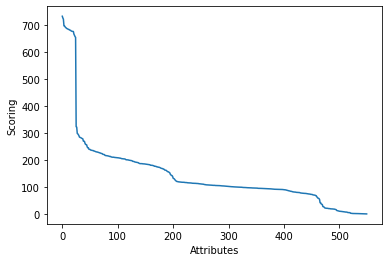

In [38]:
# We want to rank all attributes, and the best ones will be selected later
selector = SelectKBest(f_regression, k="all")
selector.fit(X_train, y_train)
sorted_attributes = np.argsort(-selector.scores_)
sorted_scores = np.sort(-selector.scores_)
for index,element in enumerate(zip(sorted_attributes, sorted_scores)):
    print(element)
    if index>10: break
        
plt.plot(-sorted_scores)
plt.xlabel('Attributes')
plt.ylabel('Scoring')
plt.show()

From the plot and after expanding the list, we can see that there is a major break in the selector scores after the 25th attribute, and the attributes that have the highest scores correspond to the following variables in the original dataset:

In [39]:
Energy_data = df.drop(columns=['steps', 'month', 'day', 'hour', 'year'])
variables = list(Energy_data.columns) 
list( variables[i] for i in sorted_attributes[:25] )

['p59.162.10',
 'cape.25',
 'p59.162.8',
 'p59.162.7',
 'p59.162.5',
 'p59.162.21',
 'p59.162.17',
 'p59.162.19',
 'p59.162.2',
 'p59.162.3',
 'p59.162.4',
 'p59.162.22',
 'p59.162.20',
 'p59.162.18',
 'p59.162.13',
 'p59.162.1',
 'p59.162.14',
 'p59.162.16',
 'p59.162.6',
 'p59.162.11',
 'p59.162.9',
 'p59.162.12',
 'p59.162.15',
 'p59.162.23',
 'p59.162.24']

We can see that out of this 25 attributes, 24 are named as p59.162._, the last digits corresponding to the location in the map (25 locations).

By doing some research in the European Centre for Medium-Range Weather Forecasts (ECMWF) website, we have found that p59.162 corresponds to the **Vertical integral of kinetic energy** measured in J/m^2. So, we can see that having a good measurement of this components for all the positions is key to have a good model. 

The third highest scoring attribute, however, is named as cape.25. According to the ECMWF website, cape corresponds to **Convective available potential energy**. This is an indication of the instability (or stability) of the atmosphere and can be used to assess the potential for the development of convection, which can lead to heavy rainfall, thunderstorms and other severe weather. So by knowing the Convective available potential energy at the most continental point in the grid (position 25) we can also have a good idea of the energy that will be produced.  

In [40]:
# trying a decision tree with only these 25 attributes
attr25_energy = sorted_attributes[:25]
X_train25 = X_trainval[:,attr25_energy]
X_test25 = X_test[:,attr25_energy]

clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train25, y_trainval)
print(f'{metrics.mean_absolute_error(y_test, clf.predict(X_test25))} <- Absolute error with only 25 attributes')

696.968018957346 <- Absolute error with only 25 attributes


It is impressive to see that with only 25 attributes the error is only double as before, which is of course a very big error, but nevertheless it is interesting to note.

It is also interesting to see that models change their predictive level according to the order of the attributes, as an example, we can see below a Decision Tree with the attributes in an unordered fashion, and later in an ordered fashion, from most important to least, according to the SelectKBest algorithm.

In [41]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_trainval, y_trainval)

print(metrics.mean_absolute_error(y_test, clf.predict(X_test)))

393.0906066350711


In [42]:
X_train_new = X_trainval[:,sorted_attributes]
X_test_new = X_test[:,sorted_attributes]

clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train_new, y_trainval)
print(metrics.mean_absolute_error(y_test, clf.predict(X_test_new)))

396.8236398104265


Even if the difference is not great, there exist however a difference in the performance simply by changing the order of the attributes.

**Number of Attributes as an Extra Hyper Parameter**

We have shown that the number of attributes chosen has a big impact on the resulting score. Therefore, by selecting the number of input attributes as an extra HyperParameter, we can optimize the number of attributes to use and see if we get a similar or even better result when we reduce them. 

In [43]:
def objective(trial):
    
    xgb_kbest = Pipeline([
      ('feature_selection', SelectKBest(f_regression, k = trial.suggest_int("feature_selection__k",1,X_trainval.shape[1]))),
      ('regression', xgb.XGBRegressor(**xgb_optuna.best_params))
                        ])

    scores = -cross_val_score(xgb_kbest, X_trainval, y_trainval, 
                              scoring='neg_mean_absolute_error', 
                              n_jobs=1,
                              cv=tr_val_partition)
    return scores.mean() 

np.random.seed(0)
xgb_kbest = optuna.create_study(direction="minimize")
xgb_kbest.optimize(objective, n_trials=20, n_jobs=4)

In [44]:
xgb_kbest.best_params

{'feature_selection__k': 264}

In [45]:
Final = Pipeline([
  ('feature_selection', SelectKBest(f_regression, k=xgb_kbest.best_params['feature_selection__k'])),
  ('regression', xgb.XGBRegressor(**xgb_optuna.best_params))
])

Final.fit(X_train_new,y_trainval)
print(metrics.mean_absolute_error(y_test, Final.predict(X_test_new)))

291.8099150741541


**To answer to the first question:**

We have seen that some attributes are more important than others, and that the component *Vertical integral of kinetic energy* (p59.162) is key, since in the top 25 components, 24 are related to this. 

We have used Optuna to compute the most optimal number of attributes to select. And by means of the SelectKBest method and a pipeline to be able to select the top attributes, we have computed the mean absolute error and we see that it selects only 264 attributes while delivering an error score of 291.81. 

Therefore we can say that it is definetely possible to achieve a relatively good score by using only 264 attributes.

**Question 2**
- *Is it enough to use only the attributes for the actual Sotavento location?*

We need to select only the variables associated to the location 13. These variables all end with .13 in their names, when seen in the original dataset. 
Therefore we must select only these variables and run the regression model only with those variables.

In [46]:
# select only variables associated with .13
df13 = df[['energy']+list(filter(re.compile(".*13$").match, df.columns))]
X_13 = df13.values[:,1:]
y_13 = df13.values[:,0]

X_train_13, y_train_13 = X_13[:trainlen, :], y_13[:trainlen]
X_val_13, y_val_13 = X_13[trainlen: trainlen + vallen, :], y_13[trainlen: trainlen+vallen]
X_trainval_13, y_trainval_13 = X_13[: trainlen + vallen, :], y_13[: trainlen + vallen]
X_test_13, y_test_13 = X_13[trainlen + vallen:, :], y_13[trainlen + vallen:]

In [47]:
# run the HPT method with this dataset
traindata_13 = lgb.Dataset(X_train_13, label=y_train_13)
def objective(trial):
                
    param = {"learning_rate": trial.suggest_float("learning_rate",0.01,1),
             "num_iterations" : trial.suggest_int('num_iterations',1,200),
             "subsample" : trial.suggest_categorical("subsample", [0.6,0.7,0.75,0.8,0.85,0.9,0.95]),
             "max_depth" : trial.suggest_int('max_depth',1,20),
             "min_child_weight" : trial.suggest_int("min_child_weight",1,10),
             "colsample_bytree" : trial.suggest_float('colsample_bytree',0.3,0.8),
             "reg_alpha" : trial.suggest_categorical("reg_alpha", [0, 0.001, 0.005, 0.01, 0.05]),
             "num_leaves" : trial.suggest_int('num_leaves',2,31),
             "verbosity":-1,
             "force_col_wise":True
            }
    
    lgb_opt = lgb.train(param, traindata_13, verbose_eval=False)
    return metrics.mean_absolute_error(y_val_13, lgb_opt.predict(X_val_13))

np.random.seed(0)
lgb_optuna_13 = optuna.create_study(direction="minimize")
lgb_optuna_13.optimize(objective, n_trials=20, n_jobs=1)

lgb_optuna_13_sum = lgb_optuna_13.best_params.copy()
lgb_optuna_13_sum['best score']= round(lgb_optuna_13.best_value,7)
lgb_optuna_13_sum

{'best score': 284.8005156,
 'colsample_bytree': 0.5984256972320868,
 'learning_rate': 0.018263189395308226,
 'max_depth': 18,
 'min_child_weight': 4,
 'num_iterations': 179,
 'num_leaves': 20,
 'reg_alpha': 0.01,
 'subsample': 0.95}

In [48]:
SPACE = [
   Real(0.01, 0.5, name='learning_rate'),
   Integer(1, 15, name='max_depth'),
   Integer(1,10, name="min_child_weight"),
    Categorical([0.6,0.7,0.75,0.8,0.85,0.9,0.95],name="subsample"),
    Real(low = 0.3, high = 0.8,name="colsample_bytree"),
    Categorical([0, 0.001, 0.005, 0.01, 0.05],name="reg_alpha"),           
   Integer(2, 31, name='num_leaves')]

@use_named_args(SPACE)
def objective(**params):
    params['verbosity'] = -1
    params['force_col_wise'] = True
    lgb_opt = lgb.train(params, traindata_13)
    return metrics.mean_absolute_error(y_val_13, lgb_opt.predict(X_val_13))


results_13 = forest_minimize(objective, SPACE, n_calls=20, n_jobs=1)
lgb_bayes_13_best_params = {i.name:j for (i,j) in zip(SPACE, results_13.x)}

lgb_bayes_13_sum = lgb_bayes_13_best_params.copy()
lgb_bayes_13_sum['best score']= round(results_13.fun,7)
lgb_bayes_13_sum

{'best score': 280.6472071,
 'colsample_bytree': 0.6157285473753014,
 'learning_rate': 0.05942362770821249,
 'max_depth': 9,
 'min_child_weight': 1,
 'num_leaves': 30,
 'reg_alpha': 0,
 'subsample': 0.95}

In [51]:
# take the parameters of the lowest error
best_params_13 = lgb_bayes_13_best_params
if lgb_optuna_13.best_value < results_13.fun:
    best_params_13 = lgb_optuna_13.best_params
    
# fit the model and predict the results
final_13 = lgb.train(best_params_13, lgb.Dataset(X_trainval_13, label=y_trainval_13))
final_13_score = metrics.mean_absolute_error(y_test_13, final_13.predict(X_test_13))
final_13_score

292.89596257707177

**To answer to the second question**

It seems as though the outer error does not differ greatly when taking just the predictors of Sotavento instead of all of the predictors to predict the energy levels. This may indicate that taking all 500+ parameters might be too much for the model and could be actually creating sources of error. 

We have shown that taking only 264 attributes or even only the 13 parameters from the Sotavento location has a very similar error value than taking the whole dataset with more than 500 variables.

### Conclusion

To conclude, we have shown and proved 5 different methods to predict the energy output given different parameters from 25 locations near the Sotavento wind energy plant, in Galicia. These 5 methods were the following: 

* KNN
* Random Forest
* Gradiant Boosting
* XGBoost
* LightBoost

XGBoost and LightBoost are variations of the Gradient Boosting method. We have seen that the method that delivers the best results in the shortest time is the LighBoost method, although the XGBoost method does not fall behind by far. 

We have seen that the different hyperparameters obtained through the different methods (SkOpt or Optuna) perform different and are not always the same. Thus we cannot conclude whci of the two optimization methods is the best one. And we recommend always the use of both.

Finally, we have seen that there is no need of using the whole 500+ available variables to make accurate predictions, we have seen in Part II of the report, that with only 264 variables we achieve a very similar error value. And even more interesting is that with only the attirbutes at location 13 (Sotavento), we obtained no significance difference than using all attributes and in significantly less time.